# Trivial clustering based approach


In [1]:
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
from random import shuffle
from Bio.Align.Applications import MuscleCommandline
from Bio import AlignIO
from skbio.alignment import local_pairwise_align_ssw
from skbio import DNA
from include import *
import itertools
import operator
import time

In [2]:
# Read data
orig_seqs = file_to_list("data/File1_ODNA.txt")
#filename = "/Users/reinhardheckel/Research/data/DNA_data/N378/Reads/I16_S2_R1_001.fastq"
filename = "data/I16_S2_R1_001.fastq"
seqs = fastq_to_list(filename)

In [3]:
print("all sequences: ", len(seqs))
print("all orig sequences: ", len(orig_seqs))
seqs = [seq for seq in seqs if len(seq) >= 55]
print("all long sequences: ",  len(seqs))
# random sample the space
sample_size = int(5e5)
indeces = np.ndarray.tolist(np.random.randint(0,len(seqs),size=(1,sample_size)))[0]
seqs = [seqs[i] for i in indeces]

all sequences:  29303855
all orig sequences:  16383
all long sequences:  15940389


In [4]:
def fraction_recovered(candidates,orig_seqs):
    d = {}
    for seq in orig_seqs:
        d[seq] = 0
    for cand in candidates:
        if cand in d:
            d[cand] += 1
    av = sum([ d[seq]>0 for seq in d]) / len(d)
    print("Fraction of recovered sequences: ", av )
    if av>0:
        print("Fraction of recovered sequences: ", sum([ d[seq] for seq in d]) / len(d) / av )

In [5]:
def errorprob(candidates,orig_seqs):
    ctr = 0
    d = {}
    for seq in orig_seqs:
        d[seq] = 0
    for cand in candidates:
        if cand in d:
            ctr += 1
    print("Fraction of error free sequences: ", ctr/len(candidates) )

length distribution nucleotides:


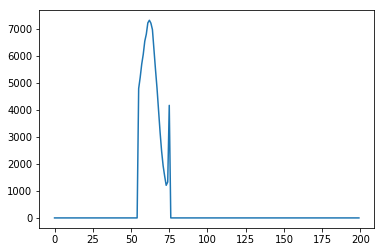

In [6]:
l, nuc, n =  seq_stats(seqs)
print("length distribution nucleotides:")
plt.plot(l)
plt.show()

In [8]:
av = 0
for leng,num in enumerate(l):
    av += leng*num
print("average length:", av/sum(l))    

average length: 63.14164


In [9]:
fraction_recovered([c[:60] for c in seqs],orig_seqs)

Fraction of recovered sequences:  0.0030519440883843008
Fraction of recovered sequences:  1.0


In [10]:
fraction_recovered(seqs,orig_seqs)

Fraction of recovered sequences:  0.0


In [11]:
errorprob([c[:60] for c in seqs],orig_seqs)

Fraction of error free sequences:  0.0005


In [11]:
errorprob(seqs,orig_seqs)

Fraction of error free sequences:  0.0


In [25]:
len(results)
f = open("DNAfragStichedMozartFilteredFile1_.txt","w")
for seq in seqs:
    if len(seq) >= 55:
        f.write(seq[:65] + '\n')
f.close()

## Clustering 

Cluster by simply looking at the nbeg first entries of each sequence

In [20]:
#===== assign numbers to shingles of each sequence=====#
def kmerDNA(seq,k=3):
    kmer = []
    for ell in range(len(seq)-k+1):
        nstr = seq[ell:ell+k]
        index = 0
        for j,c in enumerate(nstr):
            if c == 'A':
                i = 0
            elif c == 'C':
                i = 1
            elif c == 'G':
                i = 2
            elif c == 'T':
                i = 3
            else:
                index = -1
                break
            index += i*(4**j)
        kmer += [index]
    return kmer
#=====min-hash object=====#
class minhashsig():
    # min-hash of k-mers
    def __init__(self,m,k):
        # m is the number of signatures
        self.tables = [np.random.permutation(4**k) for i in range(m)]
        self.k = k
    def generate_signature(self,seq):
        kmer = kmerDNA(seq,self.k)
        sig = [ min([table[i] for i in kmer]) for table in self.tables]
        return sig
#=====pair detection=====#
def extract_similar_pairs(sigs,m,k_lsh,ell_lsh,maxsig):
    # sigs: minhash signatures
    # ell_lsh: number of LSH signatures
    # k_lsh: number of MH signatures to be concatenated
    
    #pairs = set([])
    
    # generate ell_lsh random indices
    for ell in range(ell_lsh):
        pairs = set([])
        lshinds = np.random.permutation(m)[:k_lsh]
        # generate LSh signatures
        lshsigs = []
        for sig in sigs:
            lshsig = 0
            for i,lshind in enumerate(lshinds):
                lshsig += sig[lshind]*(maxsig**i)
            lshsigs += [lshsig]
        d = {}
        for ind,sig in enumerate(lshsigs):
            if sig in d:
                d[sig] += [ind]
            else:
                d[sig] = [ind]
        for candidates in d.values():
            if len(candidates) > 1:
                for pair in itertools.combinations(candidates,2):
                    pairs.add(pair)
        yield pairs
    #return pairs
#=====form clusters based on pairs=====#
def center_cluster(pairs,L):
    clusters = {}
    hold = 0
    counter = 0
    vals = []
    while hold==0:
        
        try:
            s = time.time()
            pairs_sort = list(next(pairs))
            print("Pair Extraction time for LSH",counter,":",time.time()-s,"---","#pairs:",len(pairs_sort))
            s = time.time()
            pairs_sort.sort()
            print("Pair Sorting time for LSH",counter,":",time.time()-s)
        
            s = time.time()
            for (u,v) in pairs_sort:
                if u in clusters:
                    clusters[u] += [v]
                    #if v not in vals and v not in clusters:
                        #clusters[u] += [v]
                        #vals += [v]
        
                if v in clusters:
                    clusters[v] += [u]
                    #if u not in vals and u not in clusters:
                        #clusters[v] += [u]
                        #vals += [u]
        
                if v not in clusters and u not in clusters:
                    clusters[u] = [v]
                    #if v not in vals and u not in vals:
                        #clusters[u] = [v]
                        #vals += [v]
            print("Clustering time for LSH",counter,":",time.time()-s,'\n')
        except StopIteration:
            hold = 1
            print("level_1 clustering finished")
        counter += 1
    # remove repeated ones
    for d in clusters:
        clusters[d] = list(set(clusters[d]))
    list_clusters = clusters   
    #list_clusters = []
    #for d in clusters:
        #list_clusters += [ [d]+clusters[d] ]
        
    # find a cluster for each of the left-outs
    #left_outs = []
    #for i in range(L):
        #if i not in vals and i not in clusters:
            #left_outs += [i]
    #for index in left_outs:
        #flag = 0
        #c = -1
        #for (u,v) in pairs_sort:
            #if u == index:
                #flag = 1
                #c = v
                #break
            #elif v == index:
                #flag = 1
                #c = u
                #break
        #if flag == 1:
            #for j in range(len(list_clusters)):
                #if c in list_clusters[j]:
                    #list_clusters[j] += [index]
                    #break
    #print("level_2 clustering finished")
    return list_clusters
#=====max matching=====#
def max_match(seq1,seq2):
    alignment,score,start_end_positions \
        = local_pairwise_align_ssw(DNA(seq1) , DNA(seq2) , match_score=2,mismatch_score=-3)
    a = str(alignment[0])
    b = str(alignment[1])
    ctr = 0
    for i,j in zip(a,b):
        if i==j:
            ctr += 1
    return ctr
#=====filter pairs=====#
def filter_pairs(pairs,seqs,maxmatch=40):
    filtered_pairs =[]
    hold = 0
    counter = 0
    while hold ==0:
        try:
            s = time.time()
            pairset = next(pairs)
            print("(MAXMATCH)Pair Extraction time for LSH",counter,":",time.time()-s,len(pairset))
            s = time.time()
            for (u,v) in pairset:
                score = max_match( seqs[u] , seqs[v] )
                if score>=maxmatch:
                    filtered_pairs += [(u,v)]
            print("filtering these pairs takes:",time.time()-s,len(filtered_pairs))
            counter += 1
            yield filtered_pairs
        except StopIteration:
            hold = 1
            yield [(0,0)]
    #return filtered_pairs
#=====LSH clustering (main function)=====#
def lsh_cluster(seqs,m,k,k_lsh=2,ell_lsh=4,maxmatch=10):
    s = time.time()
    minhash = minhashsig(m,k)
    sigs = [minhash.generate_signature(seq) for seq in seqs]
    print("MH time:",time.time()-s)
    maxsig = 4**k
    pairs = extract_similar_pairs(sigs,m,k_lsh,ell_lsh,maxsig)
    if maxmatch>0:
        f_pairs = filter_pairs(pairs,seqs,maxmatch)
        clusters = center_cluster(f_pairs,len(seqs))
    else:
        clusters = center_cluster(pairs,len(seqs))
    return clusters

In [26]:
k,m,k_lsh,ell_lsh = 6,25,5,50
maxmatch = 0

start = time.time()
clusters = lsh_cluster(seqs,m,k,k_lsh,ell_lsh,maxmatch)
end = time.time()

print("Runtime:",end-start)
len(clusters)

MH time: 140.2178852558136
Pair Extraction time for LSH 0 : 3.1459875106811523 --- #pairs: 597013
Pair Sorting time for LSH 0 : 0.657869815826416
Clustering time for LSH 0 : 0.15642762184143066 

Pair Extraction time for LSH 1 : 4.5134758949279785 --- #pairs: 615211
Pair Sorting time for LSH 1 : 0.6965057849884033
Clustering time for LSH 1 : 0.30976033210754395 

Pair Extraction time for LSH 2 : 3.2004053592681885 --- #pairs: 606420
Pair Sorting time for LSH 2 : 0.6910064220428467
Clustering time for LSH 2 : 0.31000185012817383 

Pair Extraction time for LSH 3 : 3.2330617904663086 --- #pairs: 539024
Pair Sorting time for LSH 3 : 0.662529468536377
Clustering time for LSH 3 : 0.3580148220062256 

Pair Extraction time for LSH 4 : 4.567660331726074 --- #pairs: 571224
Pair Sorting time for LSH 4 : 0.6310334205627441
Clustering time for LSH 4 : 0.3094916343688965 

Pair Extraction time for LSH 5 : 3.290707588195801 --- #pairs: 560905
Pair Sorting time for LSH 5 : 0.6271753311157227
Clusterin

Pair Extraction time for LSH 48 : 6.556166410446167 --- #pairs: 552814
Pair Sorting time for LSH 48 : 0.6143925189971924
Clustering time for LSH 48 : 0.33427906036376953 

Pair Extraction time for LSH 49 : 4.302565813064575 --- #pairs: 547551
Pair Sorting time for LSH 49 : 0.600653886795044
Clustering time for LSH 49 : 0.29883861541748047 

level_1 clustering finished
Runtime: 404.26065278053284


129452

### Align the candidate clusters

In [37]:
results = []
clusters = list(clusters.values())
def align_clusters(clusters,masize = 15):
    ### align clusters, generate candidates
    for i, clusterinds in enumerate(clusters):
        cluster = [seqs[i] for i in clusterinds]
        if len(cluster)<=4:
            continue
        if len(cluster) > masize:
            for j in range(5):
                shuffle(cluster)
                ma = multiple_alignment(cluster[:masize])
                #seq = majority_merge(ma)
                #results.append(seq)
                results.append(ma)
        else:
            ma = multiple_alignment(cluster[:masize])
            results.append(ma)
            
        if i % 10 == 0:
            print(i/len(clusters))
            #fraction_recovered( [seq[:60] for seq in results] , orig_seqs)
s = time.time()
align_clusters(clusters)
print("Alignment Runtime:",time.time()-s)

0.0
7.72487099465439e-05
0.00023174612983963168
0.00038624354973271945
0.0009269845193585267
0.001467725488984334
0.0023947100083428607
0.002858202268022124
0.0032444458177548433
0.0033216945277013874
0.004094181627166826
0.0041714303371133705
0.004403176466953002
0.004789420016685721
0.0049439174365788095
0.005021166146525353
0.0053301609863115286
0.005716404536044248
0.005948150665883879
0.006025399375830424
0.006179896795723511
0.006411642925563143
0.007570373574761301
0.007879368414547477
0.008033865834440565
0.00811111454438711
0.008265611964280196
0.008420109384173284
0.008497358094119828
0.008651855514012916
0.009115347773692179
0.009269845193585266
0.009347093903531811
0.009424342613478355
0.009656088743317987
0.009810586163211074
0.010196829712943794
0.010583073262676513
0.010814819392516144
0.010892068102462689
0.011741803911874672
0.011819052621821216
0.011896301331767759
0.011973550041714303
0.012050798751660848
0.012591539721286654
0.01290053456107283
0.013055031980965918


0.09354818774526466
0.09401168000494392
0.09462966968451626
0.09478416710440936
0.0948614158143559
0.09493866452430244
0.09517041065414207
0.09524765936408862
0.09532490807403517
0.09547940549392825
0.0955566542038748
0.09563390291382134
0.09578840033371443
0.09602014646355406
0.09617464388344715
0.09671538485307295
0.0967926335630195
0.09686988227296604
0.09694713098291259
0.0973333745326453
0.09756512066248493
0.09764236937243148
0.09779686679232456
0.0980286129221642
0.09818311034205729
0.09841485647189692
0.09856935389179
0.0987238513116831
0.09895559744152273
0.0992645922813089
0.09941908970120199
0.10011432809072089
0.10034607422056052
0.1005005716404536
0.10057782035040015
0.10065506906034669
0.10088681519018633
0.10104131261007941
0.10127305873991904
0.10135030744986559
0.10150480486975867
0.10158205357970522
0.10220004325927758
0.10250903809906374
0.10266353551895684
0.10281803293884992
0.10304977906868955
0.10335877390847573
0.10382226616815499
0.10420850971788771
0.104440255

0.15689212990143064
0.1571238760312703
0.15720112474121684
0.15727837345116336
0.15743287087105645
0.157510119581003
0.15758736829094955
0.15774186571084262
0.1578963631307357
0.1580508605506288
0.15812810926057536
0.1582053579705219
0.15835985539041497
0.15843710410036152
0.15851435281030807
0.15866885023020116
0.15882334765009423
0.15890059636004078
0.15897784506998733
0.15913234248988042
0.15936408861972004
0.1594413373296666
0.15951858603961314
0.15959583474955968
0.15975033216945278
0.1598275808793993
0.15990482958934585
0.1599820782992924
0.1601365757191855
0.16021382442913204
0.1603683218490251
0.16044557055897166
0.1605228192689182
0.16075456539875785
0.1608318141087044
0.16098631152859746
0.16114080894849056
0.1612180576584371
0.16129530636838366
0.16160430120816982
0.16168154991811637
0.16229953959768872
0.16237678830763527
0.1624540370175818
0.16253128572752834
0.16268578314742144
0.16276303185736798
0.16284028056731453
0.16291752927726108
0.1631492754071007
0.16330377282699

0.21815035688903994
0.2183821030188796
0.21845935172882613
0.21869109785866575
0.21884559527855885
0.21900009269845194
0.2190773414083985
0.21923183882829156
0.2193090875382381
0.21938633624818465
0.2194635849581312
0.21969533108797082
0.220004325927757
0.22008157463770356
0.2201588233476501
0.22023607205759663
0.22046781818743627
0.22054506689738282
0.22069956431727591
0.22077681302722243
0.22093131044711553
0.22108580786700863
0.2212403052869017
0.22147205141674134
0.2215493001266879
0.22201279238636715
0.2223217872261533
0.22255353335599296
0.22270803077588605
0.22309427432561876
0.22324877174551186
0.2233260204554584
0.22348051787535148
0.22355776658529802
0.22363501529524457
0.2254117356240151
0.2256434817538547
0.2257979791737478
0.22602972530358742
0.22618422272348052
0.22626147143342706
0.22657046627321323
0.22680221240305287
0.22687946111299942
0.2270339585328925
0.22734295337267868
0.22742020208262523
0.22765194821246484
0.22780644563235794
0.22803819176219758
0.2283471866019

0.30667737848777926
0.30737261687729817
0.3076816117170843
0.3077588604270309
0.3084540988165498
0.3086858449463894
0.3089948397861756
0.3090720884961221
0.3093038346259617
0.3093810833359083
0.3094583320458548
0.3095355807558014
0.30969007817569444
0.31023081914532025
0.3104625652751599
0.310617062695053
0.31069431140499953
0.31077156011494605
0.31084880882489263
0.31092605753483915
0.3110033062447857
0.31131230108457186
0.31138954979451844
0.31154404721441153
0.31169854463430463
0.31185304205419767
0.31193029076414425
0.31208478818403734
0.31223928560393044
0.31270277786360967
0.31332076754318205
0.31370701109291477
0.3140160059327009
0.3140932546426475
0.3143250007724871
0.3144794981923802
0.315020239162006
0.3150974878719525
0.3154064827117387
0.31548373142168523
0.3155609801316318
0.3157154775515249
0.31602447239131104
0.31617896981120414
0.3164107159410438
0.31671971078082994
0.31726045175045575
0.31764669530018846
0.31780119272008156
0.31795569013997466
0.31803293884992123
0.318

0.4071779501282329
0.40787318851775173
0.4079504372276983
0.4080276859376448
0.4081821833575379
0.4082594320674845
0.40872292432716373
0.4090319191669499
0.4093409140067361
0.40957266013657573
0.4097271575564688
0.40980440626641534
0.41003615239625496
0.41026789852609463
0.41096313691561354
0.41104038562556006
0.4111176343355066
0.4116583753051324
0.4118128727250255
0.4125081111145444
0.4128171059543306
0.4128943546642771
0.4133578469239564
0.4138985878935822
0.4140530853134753
0.4142848314433149
0.4143620801532614
0.4149800698328338
0.4155208108024596
0.41575255693229923
0.41582980564224575
0.41598430306213885
0.41613880048203195
0.4162160491919785
0.41644779532181814
0.41667954145165775
0.4167567901616043
0.41683403887155085
0.4181472669406421
0.4185335104903748
0.4186880079102679
0.418842505330161
0.4189970027500541
0.4191515001699472
0.4193059975898403
0.4196149924296264
0.4197694898495195
0.4199239872694126
0.42054197694898493
0.4208509717887711
0.42123721533850383
0.4213144640484

0.5395049902666625
0.5397367363965022
0.5398139851064487
0.5408954670457004
0.5417452028551123
0.5422859438247382
0.5429811822142571
0.5430584309242036
0.5435219231838828
0.543676420603776
0.5443716589932948
0.5445261564131879
0.5446034051231344
0.5449123999629206
0.5450668973828137
0.5456076383524395
0.5457621357723326
0.5459938819021722
0.5463028767419584
0.5464573741618515
0.5466891202916911
0.5468436177115842
0.5469981151314773
0.5474616073911566
0.5476161048110496
0.5476933535209962
0.5484658406204617
0.5486975867503012
0.5490065815900874
0.5490838303000339
0.5496245712696598
0.5497018199796063
0.5501653122392856
0.5504743070790717
0.5505515557890184
0.5507060532089114
0.5513240428884838
0.551787535148163
0.5518647838581096
0.5520192812780027
0.5520965299879492
0.5521737786978957
0.5522510274078423
0.5523282761177888
0.5524827735376819
0.552637270957575
0.5527917683774681
0.5529462657973612
0.5531007632172543
0.5532552606371474
0.5534097580570404
0.5536415041868801
0.5537187528968

0.7442140716250039
0.7457590458239347
0.747072273893026
0.7471495226029725
0.747226771312919
0.7473040200228657
0.7478447609924914
0.7492352377715292
0.7493124864814757
0.7503167197107808
0.7503939684207274
0.7505484658406205
0.750625714550567
0.7507802119704601
0.7508574606804066
0.7512437042301393
0.7517071964898187
0.7520161913296048
0.7523251861693909
0.7532521706887495
0.7541791552081081
0.7542564039180546
0.7547198961777338
0.7547971448876803
0.7554923832771993
0.7557241294070389
0.7558013781169854
0.7560331242468251
0.7562648703766647
0.7563421190866113
0.7568828600562371
0.7576553471557025
0.7581960881253283
0.7588140778049006
0.7591230726446868
0.7592003213546333
0.75927757006458
0.7593548187745265
0.7604363007137781
0.7606680468436177
0.76128603652319
0.7619040262027624
0.7620585236226555
0.7624447671723882
0.7632172542718536
0.7639124926613725
0.7649167258906776
0.7659209591199827
0.7663072026697154
0.7664617000896085
0.7680066742885394
0.7681611717084325
0.7701696381670426


In [38]:
import operator
def majority_merge(reads,weight = 0.4):
    # assume reads have the same lenght
    res = ""
    for i in range(len(reads[0])):
        counts = {'A':0,'C':0,'G':0,'T':0,'-':0,'N':0}
        for j in range(len(reads)):
            counts[reads[j][i]] +=1
        counts['-'] *= weight
        mv = max(counts.items(), key=operator.itemgetter(1))[0]
        if mv != '-':
            res += mv
    return res

candidates = []
for ma in results:
    candidates.append(majority_merge(ma,weight=0.5)) # 0.45
fraction_recovered( [seq[:60] for seq in candidates] , orig_seqs)

Fraction of recovered sequences:  0.09100897271561985
Fraction of recovered sequences:  2.561368209255533


In [13]:
len(results)
f = open("reads_processed_file1__.txt","w")
for seq in candidates:
    if len(seq) >= 60:
        f.write(seq[:60] + '\n')
f.close()

In [39]:
len(candidates)

77824

### Count errors in the  candidates

In [40]:
def eval_error(candidates,orig_seqs):
    short_origs = [seq for seq in orig_seqs]
    d = {}
    for seq in orig_seqs:
        d[seq] = 60

    def split(st, num=3):
        return [ st[i:i+num] for i in range(0, len(st), num) ]
    
    def sub_err(cand,orig):
        ctr = 0
        a = split(cand)
        b = split(orig)
        #for i,j in zip(cand,orig):
        for i,j in zip(a,b):
            if i != j:
                ctr += 1
        return ctr
            
    for cand in candidates:
        if cand in short_origs:
            ind = short_origs.index( cand )
            orig = orig_seqs[ind]
    
            se = sub_err(cand,orig)
            d[orig] = min(d[orig],se)
    print( sum([d[i] <= 1 for i in d]) / len(d) )
    print( len(d) )
    print( len(results) )

In [41]:
eval_error(candidates,orig_seqs)
#print(len(seqs))
#print(len(l))
#print(ctr)
#print(d)

0.0
16383
77824


In [33]:
for i in range(0,20):
    print(len(clusters[i]))

319
7
12
2
3
3
1
2
7
1
1046
1
6
5
8
30
6
302
15
289


In [32]:
len(results)

9014

In [22]:
clusters

{2: [125952,
  378371,
  295686,
  425352,
  463119,
  328079,
  498448,
  493712,
  234515,
  233877,
  351127,
  434969,
  45594,
  202395,
  45723,
  129320,
  65711,
  128688,
  438580,
  255540,
  105529,
  158140,
  48444,
  354878,
  14659,
  85444,
  136005,
  244166,
  383943,
  198343,
  361543,
  499658,
  135883,
  254797,
  438102,
  228441,
  492637,
  93406,
  209632,
  358625,
  453348,
  418660,
  337383,
  249192,
  180073,
  218472,
  122367,
  464239,
  176242,
  107763,
  308979,
  366329,
  129660,
  10493,
  407423],
 15: [295206, 74791, 384147, 168438, 389979],
 37: [256631],
 57: [351703],
 90: [473088,
  261637,
  231436,
  220174,
  146961,
  49682,
  284692,
  271905,
  357921,
  103460,
  44074,
  58411,
  294446,
  221749,
  428086,
  382007,
  439866,
  335419,
  429118,
  387656,
  198216,
  242767,
  100433,
  237654,
  276059,
  219741,
  440928,
  303210,
  176242,
  178295,
  99450,
  373374,
  124055,
  350872,
  274083,
  114341,
  374439,
  144554